<a href="https://colab.research.google.com/github/AlisionXue/Predictive-Model-Class/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=18WH0LIH0IhMlvVz2WAV9MNHFSyFeRYnD
To: /content/client_data.csv
100%|██████████| 556k/556k [00:00<00:00, 69.2MB/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

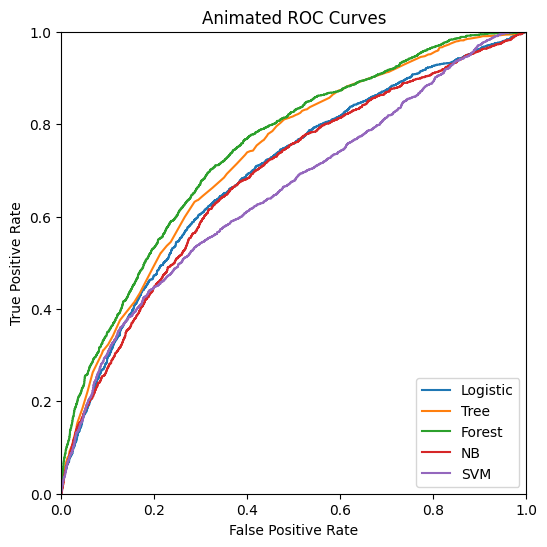

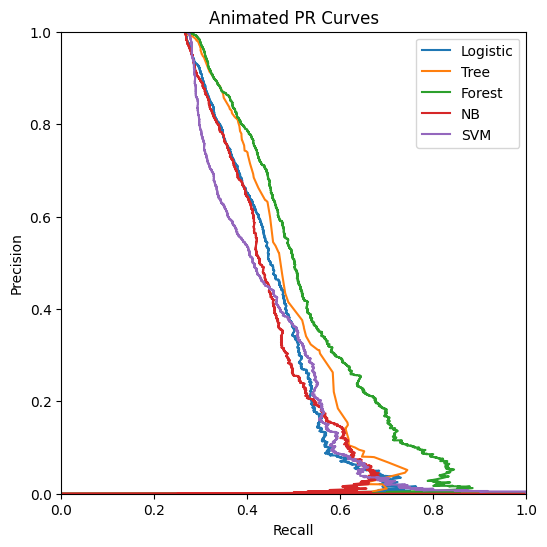

In [4]:
# —— Install dependencies —— #
!pip install -q gdown scikit-learn matplotlib pillow

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from google.colab import files

# —— 1. Download & Load Data —— #
file_id = "18WH0LIH0IhMlvVz2WAV9MNHFSyFeRYnD"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "client_data.csv", quiet=False)
data = pd.read_csv("client_data.csv")

# —— 2. Preprocessing —— #
# Assume the first column is the churn label (0/1), rest are features
target_col = data.columns[0]
X = data.drop(target_col, axis=1)
y = data[target_col].copy()

# Encode categorical features
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Keep only selected key features
selected_features = [
    'total_charges',
    'total_long_distance_charges',
    'age',
    'total_extra_data_charges',
    'total_refunds',
    'gender'
]
X = X[selected_features]

# —— 3. Train Models & Compute Curve Data —— #
models = {
    "Logistic": LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=1000),
    "Tree":     DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=2),
    "Forest":   RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10),
    "NB":       GaussianNB(),
    "SVM":      SVC(probability=True)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
roc_data = {}
pr_data  = {}

for name, model in models.items():
    all_true = []
    all_proba = []
    for train_idx, test_idx in kf.split(X, y):
        model.fit(X.iloc[train_idx], y[train_idx])
        proba = model.predict_proba(X.iloc[test_idx])[:, 1]
        all_true.append(y[test_idx])
        all_proba.append(proba)
    y_true = np.concatenate(all_true)
    y_proba = np.concatenate(all_proba)

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_data[name] = (fpr, tpr)
    rec, pre, _ = precision_recall_curve(y_true, y_proba)
    pr_data[name] = (rec, pre)

# —— 4. Plot & Save Animated ROC Curve —— #
fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Animated ROC Curves")
lines1 = {}
for name in models:
    lines1[name], = ax1.plot([], [], label=name)
ax1.legend(loc="lower right")

def update_roc(frame):
    for name in models:
        fpr, tpr = roc_data[name]
        cutoff = int(len(fpr) * frame / 100)
        lines1[name].set_data(fpr[:cutoff], tpr[:cutoff])
    return list(lines1.values())

ani_roc = animation.FuncAnimation(fig1, update_roc, frames=101, blit=True, interval=50)
roc_gif = "roc_animation.gif"
ani_roc.save(roc_gif, writer="pillow", fps=30)
files.download(roc_gif)

# —— 5. Plot & Save Animated Precision-Recall Curve —— #
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Animated PR Curves")
lines2 = {}
for name in models:
    lines2[name], = ax2.plot([], [], label=name)
ax2.legend(loc="upper right")

def update_pr(frame):
    for name in models:
        rec, pre = pr_data[name]
        cutoff = int(len(rec) * frame / 100)
        lines2[name].set_data(rec[:cutoff], pre[:cutoff])
    return list(lines2.values())

ani_pr = animation.FuncAnimation(fig2, update_pr, frames=101, blit=True, interval=50)
pr_gif = "pr_animation.gif"
ani_pr.save(pr_gif, writer="pillow", fps=30)
files.download(pr_gif)
